# histbook

Numpy-native histogramming

Numpy, Pandas, and just about every statistical toolbox has a "histogram" command, but HEP physicists would find them underwhelming:

   * they usually go directly from data in memory to a plot: no interface for accumulating data from disk, accessing bin contents programmatically, or even setting bin ranges by hand
   * they sometimes don't have weights, negative weights; and I've never seen profile plots

Could use ROOT, but then we'd have to send data *back* over the divide.

Besides, histogram interfaces can be improved.

Familiar (to HEP) interface, except that we fill a whole array instead of one value:

In [1]:
import numpy
from histbook import *
h = Hist(bin("x", 10, -5, 5))

In [2]:
h.fill(x=numpy.random.normal(-1.5, 1, 1000000))        # fill with some data

In [3]:
h.fill(x=numpy.random.normal(1.5, 1, 1000000))         # fill with more data

In [4]:
from vega import VegaLite as canvas                    # for inline plots in Jupyter
# import vegascope; canvas = vegascope.LocalCanvas()   # if you don't want to use Jupyter (traditional TCanvas in browser)

In [ ]:
h.step().to(canvas)

In [ ]:
h.pandas()

Plays well with the scientific Python ecosystem:
   * Numpy for large data input
   * [Vega-Lite](https://vega.github.io/vega-lite/) for default plotting (PyROOT is an option)
   * Pandas for tabular access

Plays well with HEP expectations:
   * re-fillable, "hadd"-able, profile plots
   * weights with sumw2, HEP-style error handling

But also:
   * all histograms are n-dimensional
   * plotting is a matter of slicing and projecting onto graphical facets (x, y, color, trellis)
   * quantities to plot are reordered to fill in an optimal way, minimizing passes over data

N-dimensional histograms:

In [ ]:
h = Hist(bin("Jet_pt", 100, 0, 100), bin("Jet_eta", 100, -5, 5), bin("Jet_phi", 100, -numpy.pi, numpy.pi))

In [5]:
import uproot
tree = uproot.open("~/storage/data/NanoAOD-DYJetsToLL.root")["Events"]
h.fill(**tree.arrays(["Jet_pt", "Jet_eta", "Jet_phi"]))

ValueError: required field 'x' not found in fill arguments

In [ ]:
h.step("Jet_eta").to(canvas)

In [ ]:
h.overlay("Jet_eta").step("Jet_pt").to(canvas)

In [ ]:
h.select("15 <= Jet_pt < 20 and -0.1 <= Jet_eta < 0.1 and Jet_phi < -pi*0.94").pandas()

These axis labels are not strings; they're algebraic expressions.

In [ ]:
h = Hist(bin("x**2", 100, 0, 100), bin("x**3", 100, 0, 100), bin("x*y", 100, 0, 100))
h.fill(x=numpy.random.normal(0, 1, 1000000), y=numpy.random.normal(0, 1, 1000000))

In [ ]:
h.fields

In [ ]:
h.axis

An n-dimensional distribution can be binned in a variety of ways in the same histogram:

   * **bin(expr, numbins, low, high)** regularly bin **low** to **high** in **numbins** bins
   * **intbin(expr, min, max)** integers from **min** to **max** (inclusive)
   * **split(expr, edges)** irregular binning at each **edge**
   * **cut(expr)** boolean expression (2 bins)
   * **groupby(expr)** categorical data (strings)
   * **groupbin(expr, binwidth, origin=0)** sparse binning

And as many dependent variables as you want can be added as profile axes:

   * **profile(expr)**

If a set of histograms are collected into a `Book`, they are all filled with a single `.fill` call that avoids repeated reading and/or repeated calculations.

In [ ]:
h = Book()
h["vs pt"] = Hist(bin("Jet_pt", 100, 0, 100), profile("Jet_chHEF"), profile("Jet_chEmEF"), profile("Jet_neHEF"))
h["vs eta"] = Hist(bin("Jet_eta", 100, -5, 5), profile("Jet_chHEF"), profile("Jet_chEmEF"), profile("Jet_neHEF"))
h["vs phi"] = Hist(bin("Jet_phi", 100, -numpy.pi, numpy.pi), profile("Jet_chHEF"), profile("Jet_chEmEF"), profile("Jet_neHEF"))

h.fill(**tree.arrays(["Jet_pt", "Jet_eta", "Jet_phi", "Jet_area", "Jet_qgl", "Jet_chHEF", "Jet_chEmEF", "Jet_neHEF"]))

In [ ]:
h["vs eta"].marker(profile="Jet_neHEF").to(canvas)

→ Write analysis scripts that look like many `TTree::Draw` commands, yet only pass over the data once.

Separately created and filled histograms can be added (hadd) or grouped (new categorical axis).

In [6]:
muonpt = Hist(bin("pt", 100, 0, 100), fill=tree.array("Muon_pt"), weight=10)
jetpt = Hist(bin("pt", 100, 0, 100), fill=tree.array("Jet_pt"), weight=1)

In [7]:
h = Hist.group(muon=muonpt, jet=jetpt)

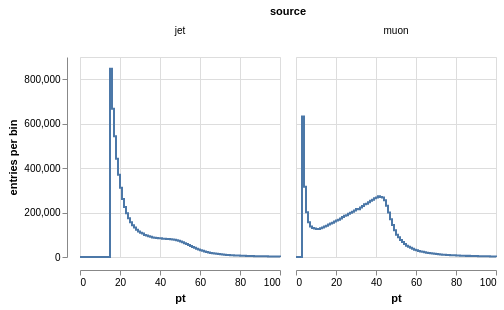

In [14]:
h.beside("source").step("pt").to(canvas)